In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from sklearn.datasets import load_diabetes

from sklearn.model_selection import train_test_split

from src.bootstrap import get_bs_theta_linreg, BootstrapLinreg
from src.amortized_bootstrap import AmortizedBootstrapLinreg
from src.utils import train_model, eval_bagging
from src.models import LinearModel

# Diabetes

In [2]:
diabetes_data = load_diabetes(as_frame=True)

X = diabetes_data['data'][['bmi', 'bp']].values
y = diabetes_data['target'].values

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [4]:
theta_bs = get_bs_theta_linreg(X_train, y_train, 1000)

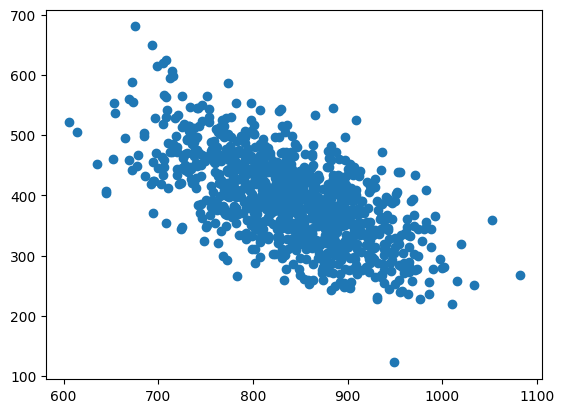

In [5]:
plt.scatter(theta_bs[:, 1], theta_bs[:, 2])

In [6]:
X_train_tensor, X_test_tensor = torch.FloatTensor(X_train), torch.FloatTensor(X_test)
y_train_tensor, y_test_tensor = torch.FloatTensor(y_train), torch.FloatTensor(y_test)

In [7]:
amortized_bootstrap = nn.Sequential(
    nn.Linear(25, 50),
    nn.ReLU(),
    nn.Linear(50, 3)
)

In [8]:
optimizer = torch.optim.Adam(amortized_bootstrap.parameters(), lr=1e-3)
criterion = nn.MSELoss()

history = train_model(X_train_tensor, y_train_tensor, amortized_bootstrap, LinearModel, optimizer, criterion, 1500, 5, 25, 5)

100%|██████████| 1500/1500 [00:07<00:00, 194.02it/s]


In [9]:
torch.save(amortized_bootstrap.state_dict(), 'checkpoints/diabetes.pth')

In [10]:
bs_linreg = BootstrapLinreg(X_train, y_train)
am_bs_linreg = AmortizedBootstrapLinreg(amortized_bootstrap)

In [11]:
z = torch.randn((1000, 25))

theta_pred = amortized_bootstrap(z).detach().numpy()

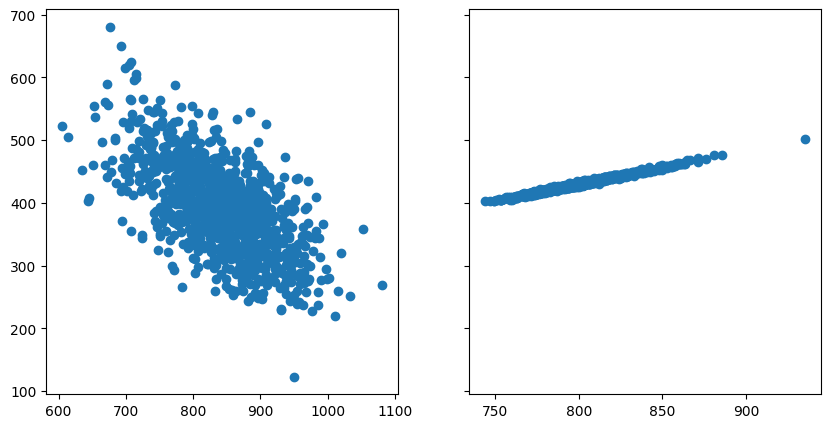

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

axes[0].scatter(theta_bs[:, 1], theta_bs[:, 2])
axes[1].scatter(theta_pred[:, 1], theta_pred[:, 2])

In [13]:
k_list = list(range(1, 26))

mse_bs = eval_bagging(bs_linreg, LinearModel, X_test, y_test, k_list)
mse_ambs = eval_bagging(am_bs_linreg, LinearModel, X_test, y_test, k_list)

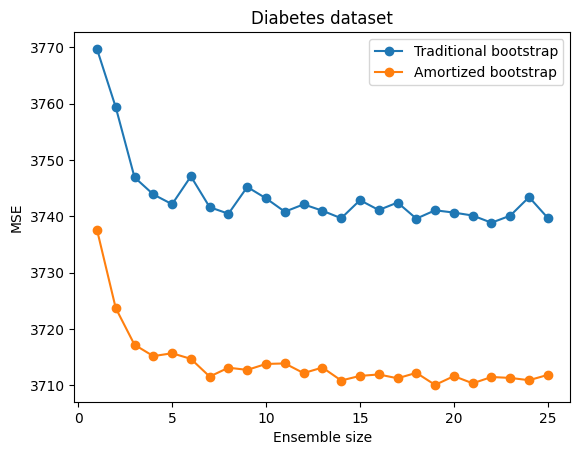

In [14]:
plt.plot(k_list, mse_bs.mean(axis=1), label='Traditional bootstrap', marker='o')
plt.plot(k_list, mse_ambs.mean(axis=1), label='Amortized bootstrap', marker='o')
plt.title('Diabetes dataset')
plt.xlabel('Ensemble size')
plt.ylabel('MSE')
plt.legend()

# Boston

In [15]:
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]

In [16]:
X = data[:, [0, 5]]
y = target

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
theta_bs = get_bs_theta_linreg(X_train, y_train, 1000)

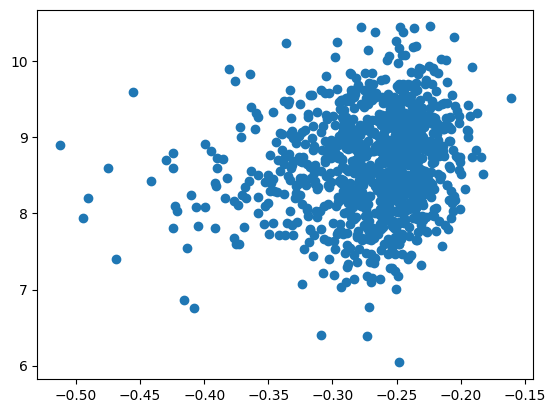

In [19]:
plt.scatter(theta_bs[:, 1], theta_bs[:, 2])

In [20]:
X_train_tensor, X_test_tensor = torch.FloatTensor(X_train), torch.FloatTensor(X_test)
y_train_tensor, y_test_tensor = torch.FloatTensor(y_train), torch.FloatTensor(y_test)

In [21]:
amortized_bootstrap = nn.Sequential(
    nn.Linear(25, 50),
    nn.ReLU(),
    nn.Linear(50, 3)
)

In [22]:
optimizer = torch.optim.Adam(amortized_bootstrap.parameters(), lr=1e-3)
criterion = nn.MSELoss()

history = train_model(X_train_tensor, y_train_tensor, amortized_bootstrap, LinearModel, optimizer, criterion, 1100, 5, 25, 5)

100%|██████████| 1100/1100 [00:04<00:00, 235.39it/s]


In [23]:
torch.save(amortized_bootstrap.state_dict(), 'checkpoints/boston.pth')

In [24]:
bs_linreg = BootstrapLinreg(X_train, y_train)
am_bs_linreg = AmortizedBootstrapLinreg(amortized_bootstrap)

In [25]:
theta_pred = am_bs_linreg.sample(1000)

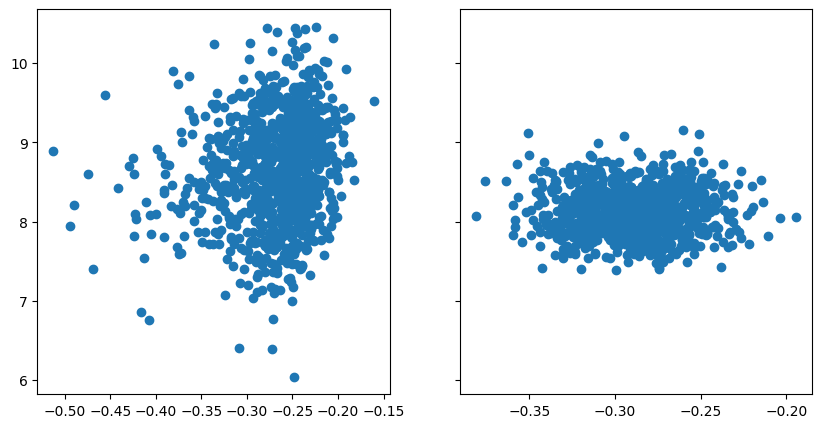

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

axes[0].scatter(theta_bs[:, 1], theta_bs[:, 2])
axes[1].scatter(theta_pred[:, 1], theta_pred[:, 2])

In [27]:
k_list = list(range(1, 26))

mse_bs = eval_bagging(bs_linreg, LinearModel, X_test, y_test, k_list)
mse_ambs = eval_bagging(am_bs_linreg, LinearModel, X_test, y_test, k_list)

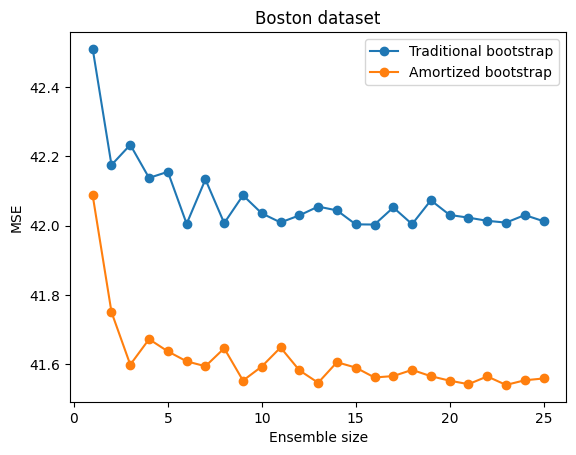

In [28]:
plt.plot(k_list, mse_bs.mean(axis=1), label='Traditional bootstrap', marker='o')
plt.plot(k_list, mse_ambs.mean(axis=1), label='Amortized bootstrap', marker='o')
plt.title('Boston dataset')
plt.xlabel('Ensemble size')
plt.ylabel('MSE')
plt.legend()